# Case Competition 1: Employee Turnover (DL Version)

In this notebook, we revisit the Hilton project and try to predict IntentToStay using deep learning instead of tree-based or other models.

In [1]:
%%capture --no-display
# Install packages:

!pip install tensorflow
!pip install scikeras
# !pip install keras
# !pip install seaborn
# !pip install category_encoders

In [2]:
# Import packages:

import sys
import pandas as pd
pd.set_option('display.max_rows', 50)
import numpy as np
np.set_printoptions(threshold=sys.maxsize)
import matplotlib.pyplot as plt
import seaborn as sns
from category_encoders import *

# sklearn imports:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

# keras imports:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Normalization, BatchNormalization
from scikeras.wrappers import KerasRegressor
from keras.optimizers import *
from keras.backend import clear_session
plt.style.use('fivethirtyeight')
%matplotlib inline

2025-03-27 22:52:29.340653: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-27 22:52:29.353951: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743115949.368327     110 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743115949.372643     110 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743115949.383368     110 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

## 1- Read & Prepare the Data:

In [3]:
trainInput = pd.read_csv("data/hilton_2023_train.csv") 
trainData = trainInput.drop(columns = 'IntentToStayHighLow')
trainLabels = LabelEncoder().fit_transform(trainInput.IntentToStayHighLow)

testInput = pd.read_csv("data/hilton_2023_test.csv")
testData = testInput.drop(columns = 'IntentToStayHighLow')
testLabels = LabelEncoder().fit_transform(testInput.IntentToStayHighLow)

In [4]:
def summarize_dataframe(df):
    missing_values = pd.concat([pd.DataFrame(df.columns, columns=['Variable Name']),
                      pd.DataFrame(df.dtypes.values.reshape([-1,1]), columns=['Data Type']),
                      pd.DataFrame(df.isnull().sum().values, columns=['Missing Values']),
                      pd.DataFrame([df[name].nunique() for name in df.columns], columns=['Unique Values'])],
                     axis=1).set_index('Variable Name')
    return pd.concat([missing_values, df.describe(include='all').transpose()], axis=1).fillna("")

In [5]:
summarize_dataframe(trainData)

,Data Type,Missing Values,Unique Values,count,mean,std,min,25%,50%,75%,max
HotelInncode,int64,0,151,7000.0,100082.859571,40.995916,100000.00,100055.00,100085.00,100116.00,100161.00
HotelBrand,int64,0,12,7000.0,5.922714,2.380002,1.00,4.00,7.00,7.00,12.00
Generation,float64,0,5,7000.0,4.213429,0.838011,2.00,4.00,4.00,5.00,6.00
Department,int64,0,40,7000.0,17.742714,8.639199,1.00,10.00,21.00,21.00,42.00
FullTimePartTime,float64,0,4,7000.0,3.338000,0.643285,3.00,3.00,3.00,3.00,6.00
...,...,...,...,...,...,...,...,...,...,...,...
GenX,int64,0,2,7000.0,0.366286,0.481823,0.00,0.00,0.00,1.00,1.00
Millennial,int64,0,2,7000.0,0.373429,0.483749,0.00,0.00,0.00,1.00,1.00
GenZ,int64,0,2,7000.0,0.034571,0.182705,0.00,0.00,0.00,0.00,1.00
MCPaysat,float64,0,5,7000.0,0.246286,1.167550,-2.62,-0.62,0.38,1.38,1.38


In [6]:
feature_list = trainData.columns
scalar = MinMaxScaler()
scalar.fit(trainData)
trainData = scalar.transform(trainData)

scalar = MinMaxScaler()
scalar.fit(testData)
testData = scalar.transform(testData)

## 2. Base Deep Learning

In [7]:
# Clear the previous model:
clear_session()

model = Sequential()
model.add(Dense(128, input_dim=trainData.shape[1], activation='leaky_relu'))
model.add(Normalization())
model.add(BatchNormalization())
model.add(Dense(64, activation='leaky_relu'))
model.add(Normalization())
model.add(BatchNormalization())
model.add(Dropout(0.8, seed=1))
model.add(Dense(1, activation='sigmoid'))
model.summary()

/opt/conda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-03-27 22:52:31.191872: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         9,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization (Normalization)   │ (None, 128)            │           257 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization_1 (Normalization) │ (None, 64)             │           129 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,563 (72.52 KB)

 Trainable params: 17,793 (69.50 KB)

 Non-trainable params: 770 (3.02 KB)

In [8]:
model.compile(loss='binary_crossentropy', 
              optimizer='adamw', 
              metrics = ['AUC'])

In [9]:
history = model.fit(trainData, trainLabels, 
          epochs=20, 
          batch_size=32, 
          shuffle=True,   
          verbose=1,
          #validation_split=0.2)
          validation_data=(testData, testLabels))

Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8437 - loss: 0.6306 - val_AUC: 0.9151 - val_loss: 0.6240
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.8881 - loss: 0.4813 - val_AUC: 0.9186 - val_loss: 0.3793
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.9111 - loss: 0.3988 - val_AUC: 0.9197 - val_loss: 0.3730
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.9179 - loss: 0.3734 - val_AUC: 0.9199 - val_loss: 0.3839
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.9214 - loss: 0.3617 - val_AUC: 0.9194 - val_loss: 0.3674
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.9137 - loss: 0.3778 - val_AUC: 0.9199 - val_loss: 0.4241
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.9164 - loss: 0.3751 - val_AUC: 0.9199 - val_loss: 0.3975
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.9253 - loss: 0.3541 - val_AUC: 0.9200 - val_loss: 0.3663
Epoch 9/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AU

dict_keys(['AUC', 'loss', 'val_AUC', 'val_loss'])


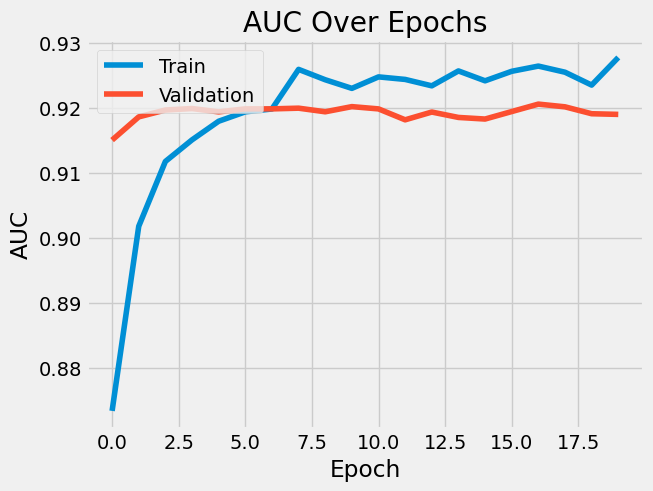

In [10]:
print(history.history.keys())

plt.plot(history.history['AUC'])
plt.plot(history.history['val_AUC'])
plt.title('AUC Over Epochs')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [11]:
predictions = (model.predict(testData) > 0.5).astype("int32").flatten()
predictionProbabilities = model.predict(testData).flatten()

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step


In [12]:
# Importing function that can be used to calculate different metrics such as accuracy, precision, recall.
from sklearn.metrics import * 

def calculateMetricsAndPrint(predictions, predictionsProbabilities, actualLabels):
    accuracy = accuracy_score(actualLabels, predictions) * 100
    precisionNegative = precision_score(actualLabels, predictions, average = None)[0] * 100
    precisionPositive = precision_score(actualLabels, predictions, average = None)[1] * 100
    recallNegative = recall_score(actualLabels, predictions, average = None)[0] * 100
    recallPositive = recall_score(actualLabels, predictions, average = None)[1] * 100
    auc = roc_auc_score(actualLabels, predictionsProbabilities) * 100
    
    print("Accuracy: %.2f\nPrecisionNegative: %.2f\nPrecisionPositive: %.2f\nRecallNegative: %.2f\nRecallPositive: %.2f\nAUC Score: %.2f\n" % 
          (accuracy, precisionNegative, precisionPositive, recallNegative, recallPositive, auc))
    
calculateMetricsAndPrint(predictions, predictionProbabilities, testLabels)

Accuracy: 84.18
PrecisionNegative: 81.43
PrecisionPositive: 87.05
RecallNegative: 86.76
RecallPositive: 81.81
AUC Score: 91.90



AUC Score = 91.904


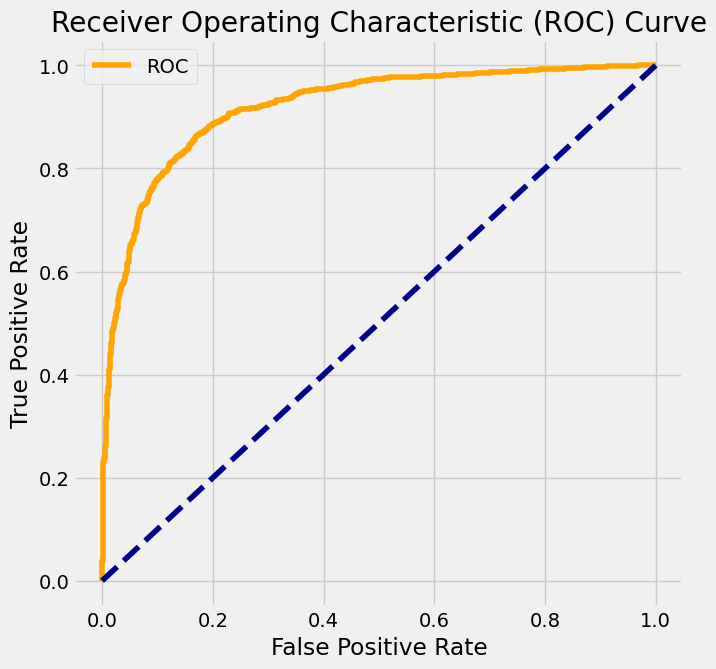

In [13]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()
    
pos_probs = predictionProbabilities

fpr, tpr, thresholds = roc_curve(testLabels, pos_probs, pos_label = 1)

# calculate scores
lr_auc = roc_auc_score(testLabels, pos_probs)
print('AUC Score = %.3f' % (lr_auc * 100))
plt.rcParams['figure.figsize'] = [7, 7]
plot_roc_curve(fpr, tpr)

## 3. Keras Tuner - Random Search

In [14]:
pip install keras-tuner

  Using cached keras_tuner-1.4.7-py3-none-any.whl.metadata (5.4 kB)
  Using cached kt_legacy-1.0.5-py3-none-any.whl.metadata (221 bytes)
Using cached keras_tuner-1.4.7-py3-none-any.whl (129 kB)
Using cached kt_legacy-1.0.5-py3-none-any.whl (9.6 kB)
Note: you may need to restart the kernel to use updated packages.


In [15]:
import keras_tuner

In [16]:
tf.keras.backend.clear_session()

def build_model(hp):
    model = keras.Sequential()
    
    units_layer1 = hp.Int('units_layer1', min_value=128, max_value=512, step=32)
    model.add(keras.layers.Dense(units_layer1, input_dim=trainData.shape[1], activation='linear'))
    model.add(keras.layers.LeakyReLU(alpha=hp.Float('leaky_alpha_layer1', 0.01, 0.9, step=0.005)))
    model.add(keras.layers.Normalization())  
    model.add(keras.layers.BatchNormalization())

    units_layer2 = hp.Int('units_layer2', min_value=64, max_value=256, step=32)
    model.add(keras.layers.Dense(units_layer2, activation='linear'))
    model.add(keras.layers.LeakyReLU(alpha=hp.Float('leaky_alpha_layer2', 0.01, 0.9, step=0.005)))
    model.add(keras.layers.Normalization())
    model.add(keras.layers.BatchNormalization())

    units_layer3 = hp.Int('units_layer3', min_value=16, max_value=64, step=16)
    model.add(keras.layers.Dense(units_layer3, activation='linear'))
    model.add(keras.layers.LeakyReLU(alpha=hp.Float('leaky_alpha_layer3', 0.01, 0.9, step=0.005)))
    model.add(keras.layers.Normalization())
    model.add(keras.layers.BatchNormalization())

    
    dropout_rate = hp.Float('dropout_rate', min_value=0.4, max_value=0.9, step=0.01)
    model.add(keras.layers.Dropout(rate=dropout_rate, seed=1))
    
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    
    model.compile(
        loss='binary_crossentropy',  
        optimizer='adamw',           
        metrics=[keras.metrics.AUC(name='auc')]
    )

    return model

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc',
    mode='max',
    patience=15,
    restore_best_weights=True
)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_auc',
    mode='max',
    factor=0.1,
    patience=5,
    verbose=1
)

tuner = keras_tuner.RandomSearch(
    build_model,
    objective='val_auc', 
    max_trials=100
)

tuner.search(trainData, trainLabels, epochs=60, validation_data=(testData, testLabels),
             callbacks=[early_stop, reduce_lr])

model = tuner.get_best_models()[0]

Reloading Tuner from ./untitled_project/tuner0.json


/opt/conda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/conda/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adamw', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Docs for model fitting: https://keras.io/api/models/model_training_apis/

Docs for the predict method: https://keras.io/api/models/model_training_apis/

In [17]:
predictions = (model.predict(testData) > 0.5).astype("int32").flatten()
predictionProbabilities = model.predict(testData).flatten()

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step


In [18]:
# Importing function that can be used to calculate different metrics such as accuracy, precision, recall.
from sklearn.metrics import * 

def calculateMetricsAndPrint(predictions, predictionsProbabilities, actualLabels):
    accuracy = accuracy_score(actualLabels, predictions) * 100
    precisionNegative = precision_score(actualLabels, predictions, average = None)[0] * 100
    precisionPositive = precision_score(actualLabels, predictions, average = None)[1] * 100
    recallNegative = recall_score(actualLabels, predictions, average = None)[0] * 100
    recallPositive = recall_score(actualLabels, predictions, average = None)[1] * 100
    auc = roc_auc_score(actualLabels, predictionsProbabilities) * 100
    
    print("Accuracy: %.2f\nPrecisionNegative: %.2f\nPrecisionPositive: %.2f\nRecallNegative: %.2f\nRecallPositive: %.2f\nAUC Score: %.2f\n" % 
          (accuracy, precisionNegative, precisionPositive, recallNegative, recallPositive, auc))
    
calculateMetricsAndPrint(predictions, predictionProbabilities, testLabels)

Accuracy: 83.87
PrecisionNegative: 87.94
PrecisionPositive: 80.94
RecallNegative: 76.87
RecallPositive: 90.30
AUC Score: 92.45



AUC Score = 92.447


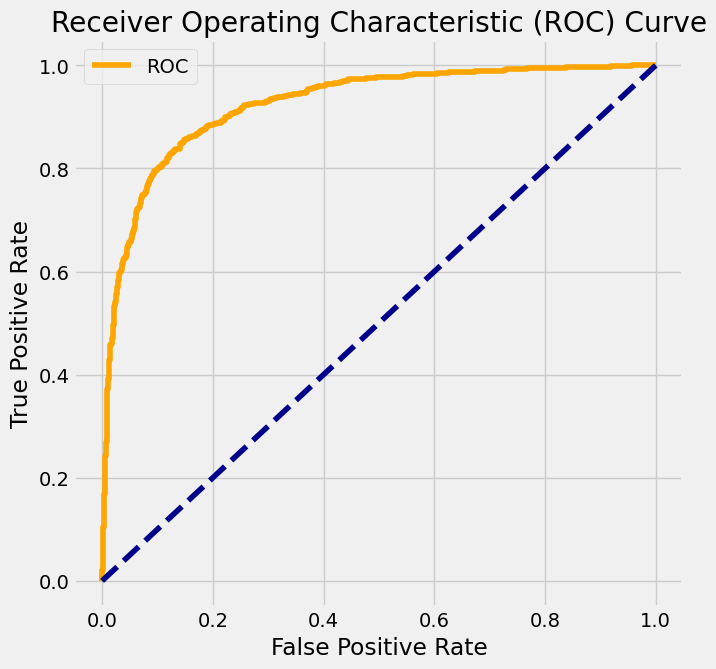

In [19]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()
    
pos_probs = predictionProbabilities

fpr, tpr, thresholds = roc_curve(testLabels, pos_probs, pos_label = 1)

# calculate scores
lr_auc = roc_auc_score(testLabels, pos_probs)
print('AUC Score = %.3f' % (lr_auc * 100))
plt.rcParams['figure.figsize'] = [7, 7]
plot_roc_curve(fpr, tpr)

## 4. Apply to Kaggle and Submit:


In [20]:
kaggleInput = pd.read_csv("data/hilton_2023_kaggle.csv")
scalar = MinMaxScaler()
scalar.fit(kaggleInput)
kaggleTest = scalar.transform(kaggleInput)
kaggleInput['score'] = model.predict(kaggleTest).flatten()
kaggleInput['id'] = kaggleInput.index

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step


In [21]:
kaggleInput[['id','score']].to_csv("data/Kaggle_Submission_M4.csv", index = False)

## 5. Experiment

In [22]:
import tensorflow as tf
from tensorflow import keras
import keras_tuner

tf.keras.backend.clear_session()

def build_model(hp):
    model = keras.Sequential()
    
    units_layer1 = hp.Choice('units_layer1', [16, 32, 48, 64])
    model.add(keras.layers.Dense(units_layer1, input_dim=trainData.shape[1], activation='linear'))
    model.add(keras.layers.LeakyReLU(alpha=hp.Float('leaky_alpha_layer1', 0.01, 0.9, step=0.005)))
    model.add(keras.layers.Normalization())  
    model.add(keras.layers.BatchNormalization())
    
    units_layer2 = hp.Choice('units_layer2', [64, 96, 128, 160, 192, 224, 256])
    model.add(keras.layers.Dense(units_layer2, activation='linear'))
    model.add(keras.layers.LeakyReLU(alpha=hp.Float('leaky_alpha_layer2', 0.01, 0.9, step=0.005)))
    model.add(keras.layers.Normalization())
    model.add(keras.layers.BatchNormalization())
    
    units_layer3 = hp.Choice('units_layer3', [128, 160, 192, 224, 256, 288, 320, 352, 384, 416, 448, 480, 512])
    model.add(keras.layers.Dense(units_layer3, activation='linear'))
    model.add(keras.layers.LeakyReLU(alpha=hp.Float('leaky_alpha_layer3', 0.01, 0.9, step=0.005)))
    model.add(keras.layers.Normalization())
    model.add(keras.layers.BatchNormalization())
    
    dropout_rate = hp.Float('dropout_rate', min_value=0.4, max_value=0.9, step=0.05)
    model.add(keras.layers.Dropout(rate=dropout_rate, seed=1))
    
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    
    model.compile(
        loss='binary_crossentropy',  
        optimizer='adamw',           
        metrics=[keras.metrics.AUC(name='auc')]
    )

    return model

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc',
    mode='max',
    patience=11,
    restore_best_weights=True
)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_auc',
    mode='max',
    factor=0.1,
    patience=5,
    verbose=1
)

# Define a custom tuner that includes batch_size as a hyperparameter.
class MyTuner(keras_tuner.RandomSearch):
    def run_trial(self, trial, *args, **kwargs):
        hp = trial.hyperparameters
        # Define a batch_size hyperparameter
        batch_size = hp.Choice("batch_size", values=[16, 32, 48, 64])
        kwargs["batch_size"] = batch_size
        return super().run_trial(trial, *args, **kwargs)

tuner = MyTuner(
    build_model,
    objective='val_auc', 
    max_trials=100
)

tuner.search(
    trainData, trainLabels,
    epochs=60,
    validation_data=(testData, testLabels),
    callbacks=[early_stop, reduce_lr]
)

model = tuner.get_best_models()[0]


Reloading Tuner from ./untitled_project/tuner0.json


/opt/conda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/conda/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adamw', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [23]:
tf.keras.backend.clear_session()

def build_model(hp):
    model = keras.Sequential()
    
    # ----- First Dense Block -----
    units_layer1 = hp.Choice('units_layer1', [16, 32, 48, 64])
    init_layer1 = hp.Choice('kernel_initializer_layer1', ['glorot_uniform', 'he_normal', 'he_uniform'])
    l2_layer1 = hp.Float('l2_reg_layer1', min_value=1e-6, max_value=1e-3, sampling='LOG', default=1e-4)
    model.add(keras.layers.Dense(units_layer1, 
                                 input_dim=trainData.shape[1], 
                                 activation='linear',
                                 kernel_initializer=init_layer1,
                                 kernel_regularizer=keras.regularizers.l2(l2_layer1)))
    model.add(keras.layers.LeakyReLU(alpha=hp.Float('leaky_alpha_layer1', 0.01, 0.9, step=0.005)))
    model.add(keras.layers.Normalization())  
    model.add(keras.layers.BatchNormalization())
    dropout_rate1 = hp.Float('dropout_rate1', min_value=0.2, max_value=0.5, step=0.05)
    model.add(keras.layers.Dropout(rate=dropout_rate1, seed=1))
    
    # ----- Second Dense Block -----
    units_layer2 = hp.Choice('units_layer2', [64, 96, 128, 160, 192, 224, 256])
    init_layer2 = hp.Choice('kernel_initializer_layer2', ['glorot_uniform', 'he_normal', 'he_uniform'])
    l2_layer2 = hp.Float('l2_reg_layer2', min_value=1e-6, max_value=1e-3, sampling='LOG', default=1e-4)
    model.add(keras.layers.Dense(units_layer2, 
                                 activation='linear',
                                 kernel_initializer=init_layer2,
                                 kernel_regularizer=keras.regularizers.l2(l2_layer2)))
    model.add(keras.layers.LeakyReLU(alpha=hp.Float('leaky_alpha_layer2', 0.01, 0.9, step=0.005)))
    model.add(keras.layers.Normalization())
    model.add(keras.layers.BatchNormalization())
    dropout_rate2 = hp.Float('dropout_rate2', min_value=0.2, max_value=0.5, step=0.05)
    model.add(keras.layers.Dropout(rate=dropout_rate2, seed=2))
    
    # ----- Third Dense Block -----
    units_layer3 = hp.Choice('units_layer3', [128, 160, 192, 224, 256, 288, 320, 352, 384, 416, 448, 480, 512])
    init_layer3 = hp.Choice('kernel_initializer_layer3', ['glorot_uniform', 'he_normal', 'he_uniform'])
    l2_layer3 = hp.Float('l2_reg_layer3', min_value=1e-6, max_value=1e-3, sampling='LOG', default=1e-4)
    model.add(keras.layers.Dense(units_layer3, 
                                 activation='linear',
                                 kernel_initializer=init_layer3,
                                 kernel_regularizer=keras.regularizers.l2(l2_layer3)))
    model.add(keras.layers.LeakyReLU(alpha=hp.Float('leaky_alpha_layer3', 0.01, 0.9, step=0.005)))
    model.add(keras.layers.Normalization())
    model.add(keras.layers.BatchNormalization())
    dropout_rate3 = hp.Float('dropout_rate3', min_value=0.2, max_value=0.5, step=0.05)
    model.add(keras.layers.Dropout(rate=dropout_rate3, seed=3))
    
    # ----- Output Layer -----
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    
    # ----- Optimizer: AdamW with tunable learning rate and weight decay -----
    learning_rate = hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG', default=1e-3)
    weight_decay = hp.Float('weight_decay', min_value=1e-6, max_value=1e-2, sampling='LOG', default=1e-4)
    optimizer = keras.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay)
    
    model.compile(
        loss='binary_crossentropy',  
        optimizer=optimizer,           
        metrics=[keras.metrics.AUC(name='auc')]
    )

    return model

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc',
    mode='max',
    patience=11,
    restore_best_weights=True
)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_auc',
    mode='max',
    factor=0.1,
    patience=5,
    verbose=1
)

# Subclass Hyperband to include batch size as a tunable hyperparameter.
class MyHyperband(keras_tuner.Hyperband):
    def run_trial(self, trial, *args, **kwargs):
        hp = trial.hyperparameters
        batch_size = hp.Choice("batch_size", values=[16, 32, 48, 64])
        kwargs["batch_size"] = batch_size
        return super().run_trial(trial, *args, **kwargs)

# Instantiate the Hyperband tuner with the custom subclass.
tuner = MyHyperband(
    build_model,
    objective='val_auc', 
    max_epochs=60,
    factor=20,
    directory='my_dir',
    project_name='extended_hyperparam_sech'
)

tuner.search(
    trainData, trainLabels,
    validation_data=(testData, testLabels),
    callbacks=[early_stop, reduce_lr]
)

model = tuner.get_best_models()[0]

Reloading Tuner from my_dir/extended_hyperparam_sech/tuner0.json


In [ ]:
pip install Torch

In [ ]:
pip install optuna

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
import optuna

if isinstance(trainData, np.ndarray):
    trainData = torch.tensor(trainData, dtype=torch.float32)
if isinstance(trainLabels, np.ndarray):
    trainLabels = torch.tensor(trainLabels, dtype=torch.float32)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class CustomNormalization(nn.Module):
    def __init__(self, mean, std):
        super(CustomNormalization, self).__init__()
        self.register_buffer('mean', mean)
        self.register_buffer('std', std)
        
    def forward(self, x):
        return (x - self.mean) / (self.std + 1e-7)

class MyModel(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, dropout_rate, use_custom_norm=False, norm_mean=None, norm_std=None):
        super(MyModel, self).__init__()
        self.use_custom_norm = use_custom_norm

        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.relu1 = nn.ReLU()
        if use_custom_norm:
            self.norm1 = CustomNormalization(norm_mean, norm_std)
        self.bn1 = nn.BatchNorm1d(hidden_dim1)
        
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.relu2 = nn.ReLU()
        if use_custom_norm:
            self.norm2 = CustomNormalization(norm_mean[:hidden_dim2], norm_std[:hidden_dim2])
        self.bn2 = nn.BatchNorm1d(hidden_dim2)
        
        self.dropout = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(hidden_dim2, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        if self.use_custom_norm:
            x = self.norm1(x)
        x = self.bn1(x)
        
        x = self.fc2(x)
        x = self.relu2(x)
        if self.use_custom_norm:
            x = self.norm2(x)
        x = self.bn2(x)
        
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

dataset = TensorDataset(trainData, trainLabels)
batch_size = 32

def objective(trial):
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-7, 1e-2, log=True)
    dropout_rate = trial.suggest_float("dropout_rate", 0.2, 0.8)
    hidden_dim1 = trial.suggest_int("hidden_dim1", 32, 256)
    hidden_dim2 = trial.suggest_int("hidden_dim2", 16, 128)
    
    input_dim = trainData.shape[1]
    model = MyModel(input_dim, hidden_dim1, hidden_dim2, dropout_rate, use_custom_norm=False)
    model.to(device)
    
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.BCELoss()
    
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    num_epochs = 10  
    for epoch in range(num_epochs):
        model.train()
        for batch_data, batch_labels in train_loader:
            batch_data = batch_data.to(device)
            batch_labels = batch_labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(batch_data)
            loss = criterion(outputs, batch_labels.unsqueeze(1).float())
            loss.backward()
            optimizer.step()
    
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch_data, batch_labels in val_loader:
            batch_data = batch_data.to(device)
            outputs = model(batch_data)
            all_preds.extend(outputs.cpu().numpy().flatten().tolist())
            all_labels.extend(batch_labels.numpy().tolist())
    
    auc = roc_auc_score(all_labels, all_preds)
    return auc

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=150)

print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

best_params = trial.params
input_dim = trainData.shape[1]
final_model = MyModel(input_dim, 
                      hidden_dim1=best_params["hidden_dim1"], 
                      hidden_dim2=best_params["hidden_dim2"], 
                      dropout_rate=best_params["dropout_rate"],
                      use_custom_norm=False)
final_model.to(device)

optimizer = optim.AdamW(final_model.parameters(), lr=best_params["lr"], weight_decay=best_params["weight_decay"])
criterion = nn.BCELoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)
num_epochs = 20
for epoch in range(num_epochs):
    final_model.train()
    train_loss = 0.0
    for batch_data, batch_labels in train_loader:
        batch_data = batch_data.to(device)
        batch_labels = batch_labels.to(device)
        
        optimizer.zero_grad()
        outputs = final_model(batch_data)
        loss = criterion(outputs, batch_labels.unsqueeze(1).float())
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * batch_data.size(0)
    train_loss /= len(train_loader.dataset)
    scheduler.step(train_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {train_loss:.4f}")
